# Convolutional Neural Network w/ TensorFlow

In this tutorial, we will build simple CNN(Convolutional Neural Network) model. 

It has 3 convolution blocks and fully-connected output layer for logistic regression. Each layers' number of units 100 at default, but you can change any size of units later on.

(In this tutorial, when we mention **convolution block**, it means a sequence of layers conducting [**convolution**] than [**pooling**].)


## 1. Training Preperation

As same as the previous secsion, we use [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

In TensorFlow, you can simply load MNIST dataset with [tensorflow.examples.tutorials.mnist](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/mnist) module.

In this notebook, note that we add helper function for initializing **convolution** and **pooling** layers.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


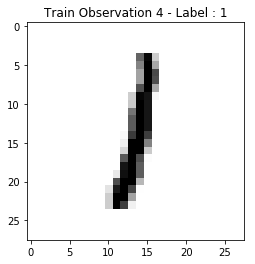

In [1]:
# load libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow import nn

# some useful functions...
def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# helper functions for initializing conv2d and max-pooling layer
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# load data
# with one_hot=True, categorical labels (e.g. {1,2,3...}) coded into binary vector form (e.g.{[1,0,0],[0,1,0]...})
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# visual check for the loaded dataset
disp_target = 4
plt.imshow(mnist.train.images[disp_target].reshape((28,28)),cmap='gray_r')
plt.title(
    'Train Observation {:d} - Label : {:d}'.format(
        disp_target,
        np.argmax(mnist.train.labels[disp_target])
    )
)

## 2. Build MLP Architecture From Scratch

Now we will build a Multi-Layer Perceptron with 3 Fully-Connected (Dense) Layer. The structure is as below equations:

\begin{align}
h_1 & = maxpool(relu(W_1 * x + b_1)) \\
h_2 & = maxpool(relu(W_2 * h_1 + b_2)) \\
h_3 & = maxpool(relu(W_3 * h_2 + b_3)) \\
h_4 & = maxpool(relu(W_4 * h_3 + b_4)) \\
h_5 & = maxpool(relu(W_5 * h_4 + b_5)) \\
o & = W_o \cdot h_5 + b_o \\
\end{align}

### 2.1. Variable Definition & Initialization w/ Random Number

In [2]:
# x = input / y = label
# first dimension of place holder set as None. With this first dimension can be dynamic size per batch
x = tf.placeholder(tf.float32, shape=[None,28*28])
x_image = tf.reshape(x, [-1,28,28,1]) # need to reshape to feed in convolution layer

y = tf.placeholder(tf.float32, shape=[None,10])

# setup parameters
W1 = weight_variable([3,3,1,32]) # (width,height,input_channel,output_channel)
b1 = bias_variable([32]) # (output_channel)

W2 = weight_variable([3,3,32,32])
b2 = bias_variable([32])

W3 = weight_variable([3,3,32,64])
b3 = bias_variable([64])

W4 = weight_variable([3,3,64,128])
b4 = bias_variable([128])

W5 = weight_variable([3,3,128,256])
b5 = bias_variable([256])

Wo = weight_variable([256,10])
bo = bias_variable([10])

### 2.2. Model Building w/ Variables

In [3]:
# 3 hidden conv blocks
h1 = max_pool_2x2(nn.relu(conv2d(x_image, W1) + b1))
h2 = max_pool_2x2(nn.relu(conv2d(h1, W2) + b2))
h3 = max_pool_2x2(nn.relu(conv2d(h2, W3) + b3))
h4 = max_pool_2x2(nn.relu(conv2d(h3, W4) + b4))
h5 = max_pool_2x2(nn.relu(conv2d(h4, W5) + b5))

# read out layer
# flattening output of last convolution block
# (4d tensor -> 2d matrix)
h5_shape = h5.get_shape().as_list()
fc_dim = np.prod(h5_shape[1:])
h5_f = tf.reshape(h5,[-1,fc_dim])

# feed it into readout layer (fc)
o = tf.matmul(h5_f,Wo) + bo

### 2.3. Setup Cost Function & Get Train Op

In this section, we will define cost function for training. We will at first get a probability distribution over categories from logits by applying Softmax function. After then, it is compared with target distribution (one-hot distribution of labels). We will minimize the distance between the two distributions (inferences and labels) by categorical cross-entropy, so we will finally have a classification model for handwritten digits!

\begin{align}
\underset{W,b}{\text{min}}\frac{1}{|M|}\sum_{x,y\in M}crossentropy(y,y')\\
y' = softmax(o)\\
\end{align}

($M$ here means mini-batch)

After we compile cost function, we can have symbolic expression for its gradient. With the computation graph of tensorflow automatically calculate partial derivatives of the cost w.r.t the parametes. Then we can simply plug them in update rule, which is [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) in our case.

$$ W \leftarrow W - \alpha \cdot \frac{\partial{C}}{\partial{W}}$$

$$ b \leftarrow b - \alpha \cdot \frac{\partial{C}}{\partial{b}}$$

(we ommit the sub letters indicating layer here)

($\alpha$ is learning rate, which is usually set with small number (e.g. 0.01))

In [4]:
# set cross_entropy loss function with y (target) and o (logits)
cross_entropy = tf.reduce_mean(
    nn.softmax_cross_entropy_with_logits(
        labels=y,
        logits=o
    )
)

# then we'll get update rule (train op) here
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(cross_entropy)

## 3. Traning

Now, we have every parts we need. Let's try the first run of CNN training.

Before get into running, we will prepare simple evaluation function to check it.

In [5]:
# binary accuracy calculation
correct_prediction = tf.equal(tf.argmax(o,1), tf.argmax(y,1))
# ...and its mean per feed
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

0th Iteration - Train Acc: 10.94% - Test Acc: 13.28%
100th Iteration - Train Acc: 78.52% - Test Acc: 75.78%
200th Iteration - Train Acc: 94.92% - Test Acc: 97.66%
300th Iteration - Train Acc: 98.44% - Test Acc: 95.31%
400th Iteration - Train Acc: 98.05% - Test Acc: 98.44%
500th Iteration - Train Acc: 97.27% - Test Acc: 99.22%
600th Iteration - Train Acc: 97.66% - Test Acc: 95.31%
700th Iteration - Train Acc: 97.66% - Test Acc: 97.66%
800th Iteration - Train Acc: 99.61% - Test Acc: 97.66%
900th Iteration - Train Acc: 98.83% - Test Acc: 99.22%


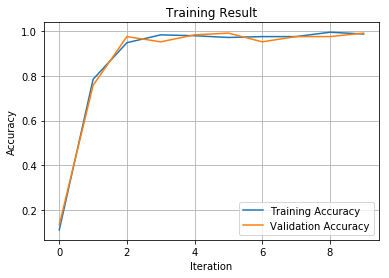

In [9]:
m = 256 # batch size
n = 1000 # number of batches to train
acc_tr = []
acc_vl = []

# Assume that you have 2GB of GPU memory and want to allocate 512MB:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)

# open an session
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

    # Initialize Variables
    sess.run(tf.global_variables_initializer())

    for j in xrange(n):
        # here we fetch a batch from dataset
        batch = mnist.train.next_batch(m)
        # update is conducted by tf
        # feed dict is key-value dictionary which
        # each keys are placeholder and
        # each values are actual value for placeholders
        sess.run(train_step,feed_dict={x:batch[0], y:batch[1]})
        
        if j%100==0:
            valid_targets = np.random.choice(mnist.test.images.shape[0],256,replace=False)
            acc_tr.append(accuracy.eval(feed_dict={x:batch[0], y:batch[1]}))
            acc_vl.append(
                accuracy.eval(
                    feed_dict={
                        x:mnist.test.images[valid_targets],
                        y:mnist.test.labels[valid_targets]
                    }
                )
            )
            
            print(
                '{:d}th Iteration - Train Acc: {:.2%} - Test Acc: {:.2%}'.format(
                    j,acc_tr[-1],acc_vl[-1]
                )
            )


fig,ax = plt.subplots()
ax.plot(acc_tr, label='Training Accuracy')
ax.plot(acc_vl, label='Validation Accuracy')
ax.grid(True)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Iteration')
ax.set_title('Training Result')
ax.legend()